### Goal:
Test the scaling factor of transformers of different sizes of model.forward wrt the number of tokens in the input.

In [1]:
!nvidia-smi

Mon Sep 26 18:43:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:87:00.0 Off |                    0 |
| N/A   39C    P0    66W / 400W |      0MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:90:00.0 Off |                    0 |
| N/A   

In [2]:
import collections

import matplotlib.pyplot as plt
import numpy
import pandas
import rich
import time
import torch
import transformers
from tqdm import tqdm

In [3]:
# seq_len = [2 ** (i // 2) if i % 2 == 0 else 2 ** (i // 2) + 2 ** (i // 2 - 1) for i in range(8, 24)]
seq_len = [4, 8, 16, 32, 128] + list(range(256, 3072, 128))
print(seq_len)

[4, 8, 16, 32, 128, 256, 384, 512, 640, 768, 896, 1024, 1152, 1280, 1408, 1536, 1664, 1792, 1920, 2048, 2176, 2304, 2432, 2560, 2688, 2816, 2944]


In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
batch_sizes = {
    "distilgpt2": 8,
    "gpt2": 4,
    "gpt2-medium": 1,
}

models = {
    name: transformers.GPT2LMHeadModel(
        transformers.GPT2Config.from_pretrained(
            name, max_position_embeddings=max(seq_len))) 
    for name in batch_sizes
}

In [5]:
durations = collections.defaultdict(list)
for name, model in tqdm(models.items()):
    rich.print(name)
    model.cuda()    
    
    # Warmup
    for len_ in tqdm(seq_len):
        input_ids = torch.randint(0, tokenizer.vocab_size, (batch_sizes[name], len_)).cuda()
        torch.cuda.synchronize()
        start = time.perf_counter()
        model(input_ids)
        torch.cuda.synchronize()
        end = time.perf_counter()

    for len_ in tqdm(seq_len):
        input_ids = torch.randint(0, tokenizer.vocab_size, (batch_sizes[name], len_)).cuda()
        torch.cuda.synchronize()
        start = time.perf_counter()
        model(input_ids)
        torch.cuda.synchronize()
        end = time.perf_counter()
        durations[name].append(end - start)
        
    del model

  0%|          | 0/3 [00:00<?, ?it/s]

distilgpt2

 33%|███▎      | 1/3 [00:17<00:34, 17.40s/it]

gpt2

 67%|██████▋   | 2/3 [00:26<00:12, 12.28s/it]

gpt2-medium

100%|██████████| 3/3 [00:32<00:00, 10.96s/it]


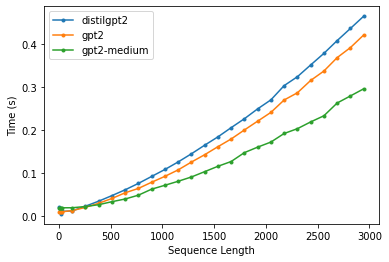

In [6]:
for k, v in durations.items():
    plt.plot(seq_len, v, label=k, marker="o", markersize=3)
    
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Time (s)")
plt.show()